In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import time
import pickle
import scipy

from xgboost import XGBClassifier
from scipy.sparse import load_npz, hstack
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.impute import  SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm,trange
from collections import defaultdict,Counter
from text_to_num import text2num,alpha2digit

import warnings

In [2]:
def read_pkl_file(files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\', file_name))
    
    name = pickle.load(open(file_paths[0], "rb"))
    ingr = pickle.load(open(file_paths[1], "rb"))
    steps = pickle.load(open(file_paths[2], "rb"))
    return name, ingr, steps

In [3]:
def model_evaluation(model, title, x,y, test_data = None):
    xtrain, xtest, ytrain, ytest = train_test_split(x,y)
    types = ['Label 1', 'Label 2', 'Label 3']#str(y.unique())

    start = time.time()
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print(f'Model {title:s} has accuracy of: {100*accuracy_score(ypred, ytest):.2f}%, runtime {time.time()-start:3.2f} seconds')
    print(classification_report(ytest, ypred,target_names=types))
    sns.heatmap(pd.DataFrame(confusion_matrix(ytest, ypred), index=types, columns=types), annot=True, fmt='d')
    plt.title("Confusion Matrix of Model "+title)
    plt.xlabel("Predicted")
    plt.ylabel("Truth Label")
    plt.yticks(rotation=0)
    plt.show()

    if not pd.isnull(test_data):
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(x)

        xtestdata = imp.transform(test_data)
        model.fit(x,y)
        ytestdata = model.predict(xtestdata)
        out = pd.DataFrame({'duration_label':ytestdata})
        out.index += 1
        out.to_csv('output/out_'+title+'.csv',index_label = 'id')

def cross_val_evaluation(model, title, x,y):
    start = time.time()
    accuracy = np.mean(cross_val_score(model,x,y,cv=10))
    runtime = time.time() - start
    print(f'Model {title:s} has accuracy of {accuracy*100:2.2f}%, runtime {runtime:3.2f} seconds')

In [28]:
curr_dir = os.path.dirname(os.path.realpath('__file__'))
train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_train.csv')
test_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_test.csv')

data_train = pd.read_csv(train_file, index_col = False, delimiter = ',')
y_train = data_train['duration_label']
data_test = pd.read_csv(test_file, index_col = False, delimiter = ',')

name, ingr, steps = read_pkl_file(['train_name_countvectorizer.pkl', 'train_ingr_countvectorizer.pkl', 'train_steps_countvectorizer.pkl'])
x_train_step = steps.fit_transform(data_train['steps'])
x_test_step = steps.transform(data_test['steps'])

x_train_ingr = ingr.fit_transform(data_train['ingredients'])
x_test_ingr = ingr.transform(data_test['ingredients'])

x_train_name = name.fit_transform(data_train['name'])
x_test_name = name.transform(data_test['name'])

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [29]:
train_data = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_train.csv').drop(['name','steps','ingredients'], axis=1)
train_data_seconds = pd.read_csv('COMP30027_2021_Project2_datasets\\input\\train_seconds.csv').drop(['name','steps','ingredients'], axis=1)
train_step_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_steps_doc2vec100.csv',header=None, names = ['step'+str(i) for i in range(100)])
train_ingr_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_ingr_doc2vec100.csv',header=None, names = ['ing'+str(i) for i in range(100)])
train_name_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\train_name_doc2vec100.csv',header=None, names = ['name'+str(i) for i in range(100)])
train_step_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_steps_doc2vec50.csv',header=None, names = ['step'+str(i) for i in range(50)])
train_ingr_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_ingr_doc2vec50.csv',header=None, names = ['ing'+str(i) for i in range(50)])
train_name_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\train_name_doc2vec50.csv',header=None, names = ['name'+str(i) for i in range(50)])

test_data = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_test.csv').drop(['name','steps','ingredients'], axis=1)
test_data_seconds = pd.read_csv('COMP30027_2021_Project2_datasets\\input\\test_seconds.csv').drop(['name','steps','ingredients'], axis=1)
test_step_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_steps_doc2vec100.csv',header=None, names = ['step'+str(i) for i in range(100)])
test_ingr_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_ingr_doc2vec100.csv',header=None, names = ['ing'+str(i) for i in range(100)])
test_name_100 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\test_name_doc2vec100.csv',header=None, names = ['name'+str(i) for i in range(100)])
test_step_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_steps_doc2vec50.csv',header=None, names = ['step'+str(i) for i in range(50)])
test_ingr_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_ingr_doc2vec50.csv',header=None, names = ['ing'+str(i) for i in range(50)])
test_name_50 = pd.read_csv('COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\test_name_doc2vec50.csv',header=None, names = ['name'+str(i) for i in range(50)])

Model Multinomial NB has accuracy of: 72.96%, runtime 0.02 seconds
              precision    recall  f1-score   support

     Label 1       0.72      0.73      0.73      4500
     Label 2       0.75      0.74      0.75      5023
     Label 3       0.55      0.62      0.58       477

    accuracy                           0.73     10000
   macro avg       0.68      0.70      0.69     10000
weighted avg       0.73      0.73      0.73     10000



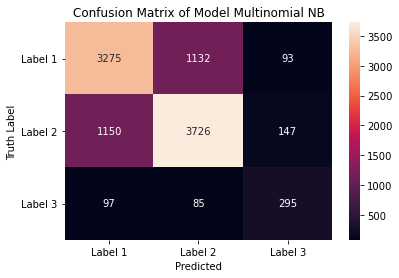

In [8]:
model_evaluation(MultinomialNB(), 'Multinomial NB', x_train_step, y_train)

Model StackingCountVecSeconds has accuracy of: 81.43%, runtime 99.88 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.81      0.81      4414
     Label 2       0.83      0.83      0.83      5105
     Label 3       0.79      0.64      0.71       481

    accuracy                           0.81     10000
   macro avg       0.81      0.76      0.78     10000
weighted avg       0.81      0.81      0.81     10000



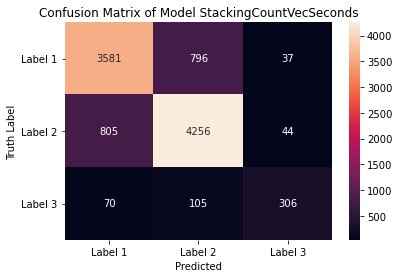

In [9]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSeconds', Xtrain,y_train, test_data=Xtest)

Model StackingCountVec has accuracy of: 79.43%, runtime 50.28 seconds
              precision    recall  f1-score   support

     Label 1       0.79      0.78      0.78      4392
     Label 2       0.80      0.83      0.81      5097
     Label 3       0.78      0.59      0.67       511

    accuracy                           0.79     10000
   macro avg       0.79      0.73      0.76     10000
weighted avg       0.79      0.79      0.79     10000



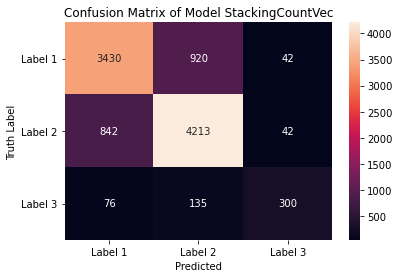

In [20]:
# Xtrain = hstack([x_train,train_data_seconds.drop('duration_label',axis=1),train_step_50])
# Xtrain.data[np.isnan(Xtrain.data)] = 0

# Xtest = hstack([x_test,test_data_seconds, test_step_50])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVec', x_train_step,y_train, test_data=x_test)

Model MultinomialNB countVec SIN has accuracy of: 72.98%, runtime 0.02 seconds
              precision    recall  f1-score   support

     Label 1       0.73      0.70      0.72      4428
     Label 2       0.74      0.77      0.76      5060
     Label 3       0.57      0.60      0.58       512

    accuracy                           0.73     10000
   macro avg       0.68      0.69      0.69     10000
weighted avg       0.73      0.73      0.73     10000



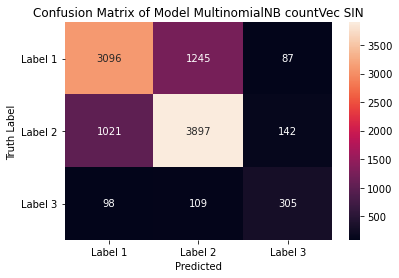

In [22]:
Xtrain = hstack([x_train_step,x_train_ingr,x_train_name])
Xtest = hstack([x_test_step,x_test_ingr,x_test_name])

model_evaluation(MultinomialNB(), 'MultinomialNB countVec SIN', Xtrain,y_train)

Model StackingCountVecStepIngrName has accuracy of: 79.39%, runtime 69.82 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.77      0.78      4499
     Label 2       0.79      0.83      0.81      4975
     Label 3       0.84      0.62      0.71       526

    accuracy                           0.79     10000
   macro avg       0.81      0.74      0.77     10000
weighted avg       0.79      0.79      0.79     10000



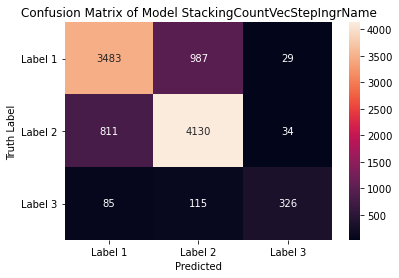

In [23]:
Xtrain = hstack([x_train_step,x_train_ingr,x_train_name])
#Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_ingr,x_test_name])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecStepIngrName', Xtrain,y_train, test_data=Xtest)

Model StackingCountVecSINSeconds has accuracy of: 81.24%, runtime 113.19 seconds
              precision    recall  f1-score   support

     Label 1       0.81      0.80      0.81      4439
     Label 2       0.81      0.84      0.83      5045
     Label 3       0.84      0.60      0.70       516

    accuracy                           0.81     10000
   macro avg       0.82      0.75      0.78     10000
weighted avg       0.81      0.81      0.81     10000



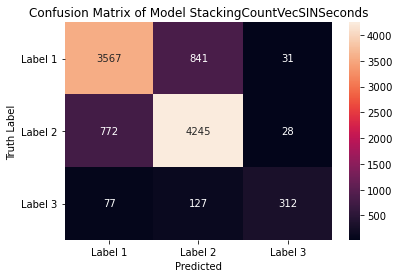

In [24]:
Xtrain = hstack([x_train_step,x_train_ingr,x_train_name,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_ingr,x_test_name,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSINSeconds', Xtrain,y_train, test_data=Xtest)

Model StackingCountVecSISeconds has accuracy of: 81.05%, runtime 90.79 seconds
              precision    recall  f1-score   support

     Label 1       0.79      0.82      0.80      4382
     Label 2       0.82      0.83      0.83      5099
     Label 3       0.82      0.60      0.69       519

    accuracy                           0.81     10000
   macro avg       0.81      0.75      0.77     10000
weighted avg       0.81      0.81      0.81     10000



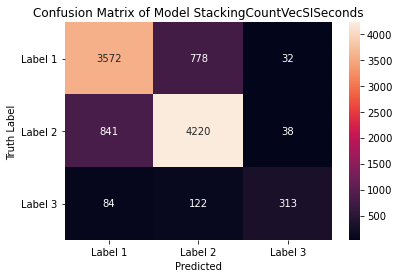

In [25]:
Xtrain = hstack([x_train_step,x_train_ingr,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_ingr,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSISeconds', Xtrain,y_train, test_data=Xtest)

Model StackingCountVecSNSeconds has accuracy of: 80.47%, runtime 101.34 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.80      0.80      4428
     Label 2       0.81      0.83      0.82      5060
     Label 3       0.80      0.64      0.71       512

    accuracy                           0.80     10000
   macro avg       0.80      0.76      0.78     10000
weighted avg       0.80      0.80      0.80     10000



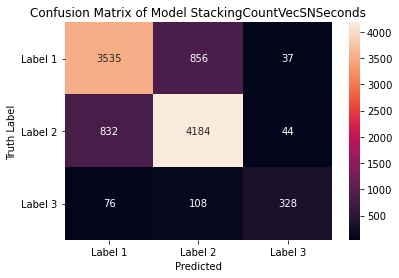

In [27]:
Xtrain = hstack([x_train_step,x_train_name,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,x_test_name,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = MultinomialNB()#KNeighborsClassifier(n_neighbors=38)
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'StackingCountVecSNSeconds', Xtrain,y_train, test_data=Xtest)

Model RandomForestCountVecSeconds has accuracy of: 79.06%, runtime 78.28 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.77      0.79      4449
     Label 2       0.78      0.85      0.81      5057
     Label 3       0.96      0.36      0.52       494

    accuracy                           0.79     10000
   macro avg       0.85      0.66      0.71     10000
weighted avg       0.80      0.79      0.79     10000



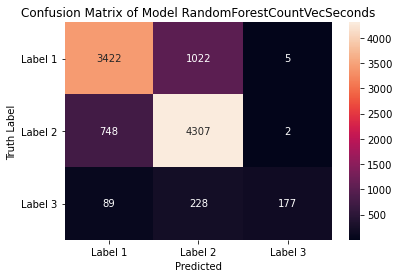

In [28]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

model_evaluation(RandomForestClassifier(), 'RandomForestCountVecSeconds', Xtrain,y_train, test_data=Xtest)

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:47:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model XGBoostCountVecSeconds has accuracy of: 81.52%, runtime 153.18 seconds
              precision    recall  f1-score   support

     Label 1       0.80      0.83      0.81      4458
     Label 2   

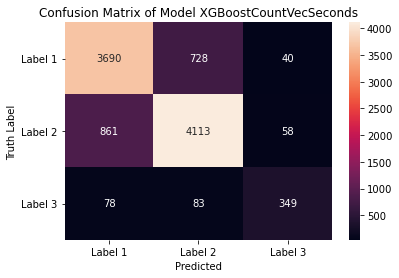

[14:49:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
from xgboost import XGBClassifier

Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

model_evaluation(XGBClassifier(), 'XGBoostCountVecSeconds', Xtrain,y_train, test_data=Xtest)

Model Stacking_RF_LR_CountVecSeconds has accuracy of: 80.26%, runtime 89.07 seconds
              precision    recall  f1-score   support

     Label 1       0.79      0.80      0.80      4401
     Label 2       0.81      0.83      0.82      5084
     Label 3       0.82      0.57      0.67       515

    accuracy                           0.80     10000
   macro avg       0.81      0.73      0.76     10000
weighted avg       0.80      0.80      0.80     10000



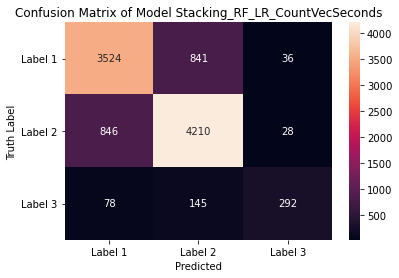

In [30]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking_RF_LR_CountVecSeconds', Xtrain,y_train, test_data=Xtest)

# Stacking (LR): XGB, LR
* CountVec 
* Seconds, n_step, n_ingr

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

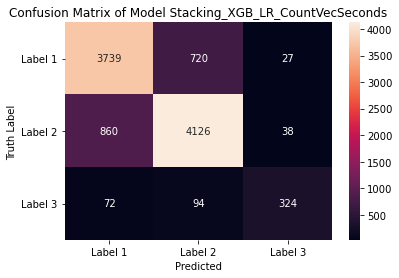

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:05:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

In [31]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds])

#c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking_XGB_LR_CountVecSeconds', Xtrain,y_train, test_data=Xtest)

# Stacking (LR): RF, XGB, LR
* CountVec 
* Seconds, n_step, n_ingr

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

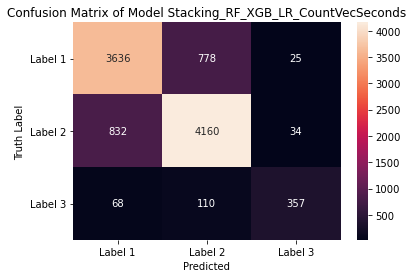

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:09:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

In [32]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking_RF_XGB_LR_CountVecSeconds', Xtrain,y_train, test_data=Xtest)

# Stacking (LR): RF, XGB, LR
* CountVec 
* Seconds, n_step, n_ingr
* top 50% feature

In [7]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1)])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds])
k_best = SelectPercentile(mutual_info_classif, percentile=50).fit(Xtrain,y_train)

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:37:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

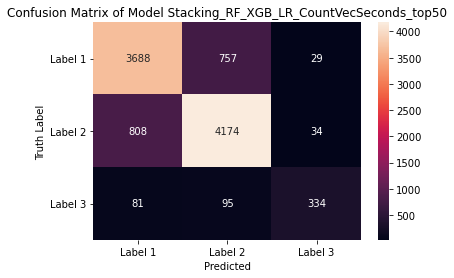

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

In [12]:
#k_best.get_support(indices=True)
xtrain = k_best.transform(Xtrain)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)

xtestdata = imp.transform(Xtest)
xtest = k_best.transform(xtestdata)

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking_RF_XGB_LR_CountVecSeconds_top50', xtrain,y_train, test_data=xtest)

# Stacking (LR): RF, XGB, LR
* CountVec 
* Seconds, n_step, n_ingr
* step_doc2vec50

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

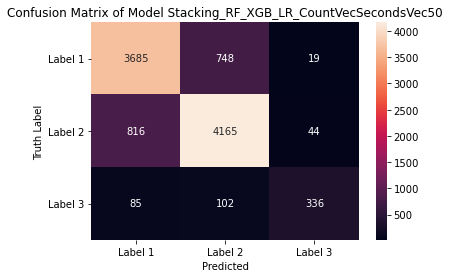

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

In [14]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking_RF_XGB_LR_CountVecSecondsVec50', Xtrain,y_train, test_data=Xtest)

# Stacking (LR): RF, XGB, LR
* CountVec 
* Seconds, n_step, n_ingr
* step_doc2vec50
* top 50% feature

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:02:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

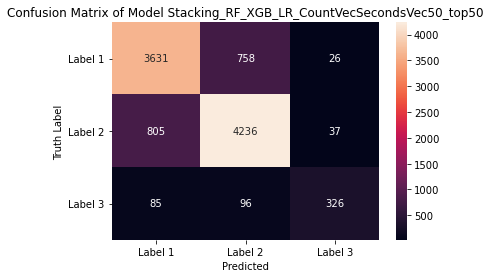

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:10:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

In [15]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])
k_best = SelectPercentile(mutual_info_classif, percentile=50).fit(Xtrain,y_train)

xtrain = k_best.transform(Xtrain)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)

xtestdata = imp.transform(Xtest)
xtest = k_best.transform(xtestdata)

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking_RF_XGB_LR_CountVecSecondsVec50_top50', xtrain,y_train, test_data=xtest)

# Stacking (LR): RF, XGB, LR
* CountVec 
* Seconds, n_step, n_ingr
* step_doc2vec100
* top 50% feature

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

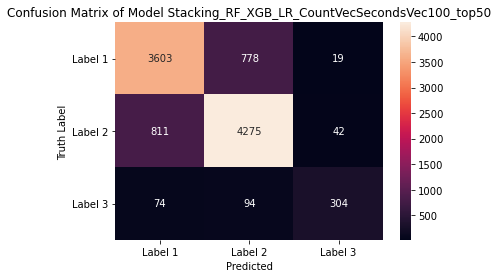

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

In [16]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_100])
Xtrain.data[np.isnan(Xtrain.data)] = 0

Xtest = hstack([x_test_step,test_data_seconds,test_step_100])
k_best = SelectPercentile(mutual_info_classif, percentile=50).fit(Xtrain,y_train)

xtrain = k_best.transform(Xtrain)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)

xtestdata = imp.transform(Xtest)
xtest = k_best.transform(xtestdata)

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

model_evaluation(sclf, 'Stacking_RF_XGB_LR_CountVecSecondsVec100_top50', xtrain,y_train, test_data=xtest)

# Trying on different % selections

## Logistic Regression

In [21]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

mdl = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
xtestdata = imp.transform(Xtest)

for p in np.arange(10,100,10):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(Xtrain,y_train)
    xtrain = k_best.transform(Xtrain)
    xtest = k_best.transform(xtestdata)
    cross_val_evaluation(mdl, f'LR_CountVecSecondsVec50_top{p}%', xtrain,y_train)

Model LR_CountVecSecondsVec50_top10% has accuracy of 77.78%, runtime 438.97 seconds
Model LR_CountVecSecondsVec50_top20% has accuracy of 77.85%, runtime 432.26 seconds
Model LR_CountVecSecondsVec50_top30% has accuracy of 77.76%, runtime 415.88 seconds
Model LR_CountVecSecondsVec50_top40% has accuracy of 78.06%, runtime 419.59 seconds
Model LR_CountVecSecondsVec50_top50% has accuracy of 78.18%, runtime 428.04 seconds
Model LR_CountVecSecondsVec50_top60% has accuracy of 78.10%, runtime 464.61 seconds
Model LR_CountVecSecondsVec50_top70% has accuracy of 77.98%, runtime 478.78 seconds
Model LR_CountVecSecondsVec50_top80% has accuracy of 77.85%, runtime 489.26 seconds
Model LR_CountVecSecondsVec50_top90% has accuracy of 77.93%, runtime 449.17 seconds


## KNN

In [22]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

mdl = KNeighborsClassifier(n_neighbors=21)

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
xtestdata = imp.transform(Xtest)

for p in np.arange(10,100,10):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(Xtrain,y_train)
    xtrain = k_best.transform(Xtrain)
    xtest = k_best.transform(xtestdata)
    cross_val_evaluation(mdl, f'KNN_CountVecSecondsVec50_top{p}%', xtrain,y_train)

Model KNN_CountVecSecondsVec50_top10% has accuracy of 78.92%, runtime 244.25 seconds
Model KNN_CountVecSecondsVec50_top20% has accuracy of 78.86%, runtime 247.18 seconds
Model KNN_CountVecSecondsVec50_top30% has accuracy of 78.86%, runtime 248.57 seconds
Model KNN_CountVecSecondsVec50_top40% has accuracy of 78.84%, runtime 264.32 seconds
Model KNN_CountVecSecondsVec50_top50% has accuracy of 78.86%, runtime 262.41 seconds
Model KNN_CountVecSecondsVec50_top60% has accuracy of 78.88%, runtime 250.14 seconds
Model KNN_CountVecSecondsVec50_top70% has accuracy of 78.89%, runtime 251.85 seconds
Model KNN_CountVecSecondsVec50_top80% has accuracy of 78.88%, runtime 259.85 seconds
Model KNN_CountVecSecondsVec50_top90% has accuracy of 78.89%, runtime 269.98 seconds


## Decision Tree

In [23]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

mdl = DecisionTreeClassifier()

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
xtestdata = imp.transform(Xtest)

for p in np.arange(10,100,10):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(Xtrain,y_train)
    xtrain = k_best.transform(Xtrain)
    xtest = k_best.transform(xtestdata)
    cross_val_evaluation(mdl, f'DT_CountVecSecondsVec50_top{p}%', xtrain,y_train)

Model DT_CountVecSecondsVec50_top10% has accuracy of 73.58%, runtime 368.75 seconds
Model DT_CountVecSecondsVec50_top20% has accuracy of 73.80%, runtime 442.17 seconds
Model DT_CountVecSecondsVec50_top30% has accuracy of 73.95%, runtime 461.10 seconds
Model DT_CountVecSecondsVec50_top40% has accuracy of 73.80%, runtime 470.62 seconds
Model DT_CountVecSecondsVec50_top50% has accuracy of 73.83%, runtime 465.70 seconds
Model DT_CountVecSecondsVec50_top60% has accuracy of 73.90%, runtime 448.95 seconds
Model DT_CountVecSecondsVec50_top70% has accuracy of 73.99%, runtime 449.56 seconds
Model DT_CountVecSecondsVec50_top80% has accuracy of 74.13%, runtime 453.19 seconds
Model DT_CountVecSecondsVec50_top90% has accuracy of 74.17%, runtime 490.65 seconds


## Random Forest

In [24]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

mdl = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
xtestdata = imp.transform(Xtest)

for p in np.arange(10,100,10):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(Xtrain,y_train)
    xtrain = k_best.transform(Xtrain)
    xtest = k_best.transform(xtestdata)
    cross_val_evaluation(mdl, f'RF_CountVecSecondsVec50_top{p}%', xtrain,y_train)

Model RF_CountVecSecondsVec50_top10% has accuracy of 80.07%, runtime 207.35 seconds
Model RF_CountVecSecondsVec50_top20% has accuracy of 79.39%, runtime 166.08 seconds
Model RF_CountVecSecondsVec50_top30% has accuracy of 78.98%, runtime 151.40 seconds
Model RF_CountVecSecondsVec50_top40% has accuracy of 78.61%, runtime 148.92 seconds
Model RF_CountVecSecondsVec50_top50% has accuracy of 78.43%, runtime 139.84 seconds
Model RF_CountVecSecondsVec50_top60% has accuracy of 78.36%, runtime 136.62 seconds
Model RF_CountVecSecondsVec50_top70% has accuracy of 78.21%, runtime 144.91 seconds
Model RF_CountVecSecondsVec50_top80% has accuracy of 77.96%, runtime 127.77 seconds
Model RF_CountVecSecondsVec50_top90% has accuracy of 78.09%, runtime 123.97 seconds


## Stacking
*Test output submitted to Kaggle for accuracy rather than cross-validation to save time*

In [ ]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
xtestdata = imp.transform(Xtest)

for p in np.arange(10,100,10):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(Xtrain,y_train)
    xtrain = k_best.transform(Xtrain)
    xtest = k_best.transform(xtestdata)
    model_evaluation(sclf, f'Stacking_RF_XGB_LR_CountVecSecondsVec50_top{p}', xtrain,y_train, test_data=xtest)

In [7]:
Xtrain = hstack([x_train_step,train_data_seconds.drop('duration_label',axis=1),train_step_50])
Xtrain.data[np.isnan(Xtrain.data)] = 0

c1 = RandomForestClassifier(n_estimators=100,min_samples_split=50,min_samples_leaf=1, criterion='gini', n_jobs=-1)
c2 = XGBClassifier()
c3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[c1,c2,c3],
                            meta_classifier=lr, use_probas=True)

Xtest = hstack([x_test_step,test_data_seconds,test_step_50])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
xtestdata = imp.transform(Xtest)

for p in np.array([55]):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(Xtrain,y_train)
    xtrain = k_best.transform(Xtrain)
    xtest = k_best.transform(xtestdata)
    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(xtrain)

    x_testdata = imp.transform(xtest)
    sclf.fit(xtrain,y_train)
    y_testdata = sclf.predict(x_testdata)
    out = pd.DataFrame({'duration_label':y_testdata})
    out.index += 1
    out.to_csv('output/out_'+f'Stacking_RF_XGB_LR_CountVecSecondsVec50_top{p}'+'.csv',index_label = 'id')

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[08:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:52:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

In [34]:
for p in np.array([43,45,47,49]):
    k_best = SelectPercentile(mutual_info_classif, percentile=p).fit(Xtrain,y_train)
    xtrain = k_best.transform(Xtrain)
    xtest = k_best.transform(xtestdata)
    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(xtrain)

    x_testdata = imp.transform(xtest)
    sclf.fit(xtrain,y_train)
    y_testdata = sclf.predict(x_testdata)
    out = pd.DataFrame({'duration_label':y_testdata})
    out.index += 1
    out.to_csv('output/out_'+f'Stacking_RF_XGB_LR_CountVecSecondsVec50_top{p}'+'.csv',index_label = 'id')

C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[02:40:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w